In [1]:
import numpy as np

import sys
import time
sys.path.append("./Models")
import os
os.system('')

import subprocess
import torch
from torch.utils.data import Dataset

import pickle
import pgzip
import copy

import datetime

import math
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

In [2]:
#Default settings for experiment
arg_model = "tsrnn" #Options: 'trfbb', 'tsrnn', 'trfbf'
arg_dset = "aep" #Datasets -- Spain: 'ree', AEP, DAYTON: 'dyt' London: 'lsm'

attr_dset_smpl_rt = 24 if arg_dset == "aep" else (48 if arg_dset == "lsm" else 24) #Samples per day. Spain, AEP: 24, London: 48
param_dset_lookback_weeks = 5
param_dset_forecast = 48 if arg_dset == "lsm" else 24
# param_dset_lookback_weeks = 9
# param_dset_forecast = 168 if arg_dset == "lsm" else 84 # 3.5days = 168
param_dset_train_stride = 48 #Choose a coprime value to the forecast so all reading frames are eventually considered
param_dset_test_stride = 'same' #tsrnn paper uses 1 week
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast

param_trf_weather = False


In [3]:
import pywt
from tqdm.auto import tqdm

# Get the maximum decomposition level
def print_maximal_decom_level(data):
    max_level = pywt.swt_max_level(data)
#     print("Maximum decomposition level:", max_level)
    
    return max_level

# SWT functions
def data_preparation(dataset, window, lev):
    '''
    Converts time series to wave
    '''
    da = []
    coeffs = []
    
#     for i in tqdm(range(len(dataset)), total=len(dataset), desc="swt"):
    for i in range(len(dataset)):
        for j in range(len(dataset[0])-window):
            coeffs_j = pywt.swt(dataset[i][j:window+j], wavelet='db2', level=lev)
            coeffs.append(coeffs_j)
            
        da.append(coeffs);
        coeffs = []
    return da

def data_reconstruction(dataset, window):
    '''
    Converts wave back to time series
    Take window-1 (last) value since we predict this value based on window
    '''
    full_recon = []
#     for i in tqdm(range(len(dataset)), total= len(dataset), desc="iswt"):
    for i in range(len(dataset)):
        da = []
        for j in range(len(dataset[0])):
            recon = pywt.iswt(dataset[i][j], 'db2')
            da.append(recon[window-1])
        full_recon.append(da)

    return full_recon


# Called because iswt cannot accept tolist() dataset
def data_organization(data):
    '''
    Reshape data back to (n,m,3,2,window_length), 
    n number of different household, m number of timelines
    where there are 3 tuples of 2 values consisting of 
    coeffs array_like Coefficients list of tuples:
    [(cAn, cDn), ..., (cA2, cD2), (cA1, cD1)]
    '''
    full_reshape_list = []
    for i in range(len(data)):
        reshape_list = []
        for j in range(len(data[0])):
            reshape_list.append([])
            for k in range(len(data[0][0])):
                reshape_list[j].append(tuple(data[i][j][k]))
        
        full_reshape_list.append(reshape_list)    
    
    return full_reshape_list

In [4]:
from aep_def import AEP #PJM AEP

#Compute remaining settings
param_dset_lookback = param_dset_lookback_weeks*7*attr_dset_smpl_rt - param_dset_forecast
if param_dset_train_stride == 'same': param_dset_train_stride = param_dset_forecast
if param_dset_test_stride == 'same': param_dset_test_stride = param_dset_forecast
attr_dset_smpl_rt = {'ree':24,'aep':24,'lsm':48, 'dyt':24}[arg_dset]

param_trf_inp_dim = {'ree':7,'lsm': 14}[arg_dset] if param_trf_weather else 1

In [5]:
#Setup Dataset
train_set = val_set = test_set = None
if arg_dset == 'aep':
    train_offset = 0
    val_offset = 9 
    #with the definitions for split boundaries, this offset for the start of the validation set ensures the start time matches the train and test sets.
    train_set = AEP(path = ".",
                    start_idx = train_offset, end_idx = (4042*24)+param_dset_forecast - 12129,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    val_set = AEP(path = ".",
                  start_idx = val_offset + (4042*24)+param_dset_forecast - 12129,
                  end_idx = (4042*24)+param_dset_forecast,
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_train_stride,
                    timestamp = False)
    test_set = AEP(path = ".",
                    start_idx = (4042*24)+param_dset_forecast, #~Last 20% of dataset
                    seq_len = param_dset_lookback,
                    pred_horz = param_dset_forecast,
                    stride=param_dset_test_stride,
                    timestamp = False)

    #Monkey patch the dataset to normalize the series
    train_set.series = (train_set.series - 9581)/(25695 - 9581)
    val_set.series = (val_set.series - 9581)/(25695 - 9581)
    test_set.series = (test_set.series - 9581)/(25695 - 9581)

print(train_set.series.shape)
print(test_set.series.shape)

torch.Size([1752, 840, 1])
torch.Size([976, 840, 1])


## Model Initialization

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [7]:
class Time2Vector(nn.Module):
    def __init__(self, seq_len):
        super(Time2Vector, self).__init__()
        self.seq_len = seq_len

        self.weights_linear = nn.Parameter(torch.rand(seq_len, requires_grad=True))
        self.bias_linear = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.weights_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        self.bias_periodic = nn.Parameter(torch.rand(seq_len), requires_grad=True)
        
        # Initialize parameters with uniform distribution
        nn.init.uniform_(self.weights_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_linear, a=0.0, b=1.0)
        nn.init.uniform_(self.weights_periodic, a=0.0, b=1.0)
        nn.init.uniform_(self.bias_periodic, a=0.0, b=1.0)

    def forward(self, x):
        x = torch.mean(x[:, :, :], dim=-1)
        time_linear = self.weights_linear * x + self.bias_linear
        time_linear = time_linear.unsqueeze(-1)

        time_periodic = torch.sin(x * self.weights_periodic + self.bias_periodic)
        time_periodic = time_periodic.unsqueeze(-1)

        return torch.cat([time_linear, time_periodic], dim=-1)

    def extra_repr(self):
        return f'seq_len={self.seq_len}'

In [8]:
class SingleAttention(nn.Module):
    def __init__(self, d_k, d_v, inp_len):
        super(SingleAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v

        self.query = nn.Linear(in_features=inp_len, out_features=d_k)
        nn.init.xavier_uniform_(self.query.weight)
        nn.init.zeros_(self.query.bias)

        self.key = nn.Linear(in_features=inp_len, out_features=d_k)
        nn.init.xavier_uniform_(self.key.weight)
        nn.init.zeros_(self.key.bias)

        self.value = nn.Linear(in_features=inp_len, out_features=d_v)
        nn.init.xavier_uniform_(self.value.weight)
        nn.init.zeros_(self.value.bias)

    def forward(self, inputs):

        q = self.query(inputs[0])
        k = self.key(inputs[1])

        attn_weights = torch.matmul(q, k.transpose(-2, -1))
        attn_weights = attn_weights / torch.sqrt(torch.tensor(self.d_k, dtype=torch.float32))
        attn_weights = F.softmax(attn_weights, dim=-1)

        v = self.value(inputs[2])
        attn_out = torch.matmul(attn_weights, v)
        return attn_out
    
class MultiAttention(nn.Module):
    def __init__(self, d_k, d_v, n_heads, inp_len):
        super(MultiAttention, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        
        self.attn_heads = nn.ModuleList([SingleAttention(d_k, d_v, inp_len) for _ in range(n_heads)])
        
        self.linear = nn.Linear(d_k * n_heads, inp_len)
        nn.init.xavier_uniform_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, inputs):
        attn = [self.attn_heads[i](inputs) for i in range(self.n_heads)]
        concat_attn = torch.cat(attn, dim=-1)
        multi_linear = self.linear(concat_attn)
        return multi_linear

In [9]:
class TransformerEncoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, inp_len, dropout=0.1):
        super(TransformerEncoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads, inp_len)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=self.ff_dim, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=seq_len, out_channels=self.ff_dim, kernel_size=1)
#         self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=8, kernel_size=1)
        self.ff_conv1D_2 = nn.Conv1d(in_channels=self.ff_dim, out_channels=seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

    def forward(self, inputs):
#         print(len(inputs))
#         print(inputs[0].shape)
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)

        # Correction for transpose
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2))
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
#         ff_layer = self.ff_conv1D_2(ff_layer).transpose(1, 2)
        ff_layer = self.ff_conv1D_2(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer
    
class TransformerDecoder(nn.Module):
    def __init__(self, d_k, d_v, n_heads, ff_dim, seq_len, inp_len, dropout=0.1):
        super(TransformerDecoder, self).__init__()
        self.d_k = d_k
        self.d_v = d_v
        self.n_heads = n_heads
        self.ff_dim = ff_dim
        self.dropout_rate = dropout

        self.attn_multi = MultiAttention(d_k, d_v, n_heads, inp_len)
        self.attn_dropout = nn.Dropout(dropout)
        self.attn_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

#         self.ff_conv1D_1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=1)
        self.ff_conv1D_1 = nn.Conv1d(in_channels=seq_len, out_channels=seq_len, kernel_size=1)
        self.ff_dropout = nn.Dropout(dropout)
        self.ff_normalize = nn.LayerNorm(normalized_shape=inp_len, eps=1e-6)

    def forward(self, inputs):
        attn_layer = self.attn_multi(inputs)
        attn_layer = self.attn_dropout(attn_layer)
        attn_layer = self.attn_normalize(inputs[0] + attn_layer)
        
        # Transpose for pytorch implementation
#         ff_layer = self.ff_conv1D_1(attn_layer.transpose(1, 2)).transpose(1, 2)
        ff_layer = self.ff_conv1D_1(attn_layer)
        ff_layer = F.relu(ff_layer)
        ff_layer = self.ff_dropout(ff_layer)
        ff_layer = self.ff_normalize(inputs[0] + ff_layer)
        return ff_layer

In [10]:
class SWT_Transformer(nn.Module):
    def __init__(self, seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim):
        super(SWT_Transformer, self).__init__()
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        self.time_embedding = Time2Vector(seq_len)
        
        self.layer1 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer2 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer3 = TransformerEncoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer4 = TransformerDecoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)
        self.layer5 = TransformerDecoder(d_k, d_v, n_heads, ff_dim, seq_len, inp_len)

        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(seq_len, 32)
        self.fc2 = nn.Linear(32, out_len)

    def forward(self, x):
        in_seq = x
        
        time_embedding = self.time_embedding(in_seq)
        x = torch.cat([in_seq, time_embedding], dim=-1)
        
        x = self.layer1((x, x, x))
        x = self.layer2((x, x, x))
        x = self.layer3((x, x, x))
        x = self.layer4((x, x, x))
        x = self.layer5((x, x, x))

        x = self.pooling(x).squeeze(2)
        x = F.dropout(x, p=0.1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=0.1)
        out = self.fc2(x)

        return out

## Create model and data tensor

In [11]:
#SWT Transformation
def swt_transformation(self_series, window, lev):
    self_series = self_series.squeeze(-1)
#     print("total series shape after squeeze: ", self_series.shape)
    self_series_numpy = self_series.numpy()
#     print("torch shape: ", self_series.shape)
#     print("numpy shape: ", self_series_numpy.shape)
#     print(self_series[0])
#     print(self_series_numpy[0])

    da = data_preparation(self_series_numpy, window, lev)
#     print(da[0][0])

    Vv = np.array(da)
#     print(Vv.shape)
#     print(Vv[0][0])

    vv = Vv.reshape(Vv.shape[0],Vv.shape[1],2*lev*Vv.shape[4])
#     print(vv.shape)


    # dataset = scaler.fit_transform(vv)

    dat = vv.reshape(Vv.shape[0],Vv.shape[1],2*lev,Vv.shape[4])
#     print(dat.shape)
    
    return dat
    
# Early stopping
class EarlyStopper:
    def __init__(self, patience=10, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False
    
class SaveBestModel:
    """
    Class to save or load the best model while training.
    """
    def __init__(
        self, best_valid_loss=float('inf')
    ):
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss, epoch, model
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
#             print(f"\nBest validation loss: {self.best_valid_loss}")
#             print(f"\nSaving best model for epoch: {epoch+1}\n")
            # Save the PyTorch model
            torch.save(model.state_dict(), 'transformer_5min.pth')
    
patience = 15
early_stopper = EarlyStopper(patience=patience, min_delta=0)
saveBestModel = SaveBestModel()

In [12]:
window = param_dset_lookback
max_level = print_maximal_decom_level(window)
lev = max_level if max_level < 3 else 3

batch_size = 256
d_k = 256
d_v = 256
n_heads = 12
ff_dim = 256
inp_len = 2*lev + 2 # 2 from time2Vector embedding
out_len = 2*lev

seq_len = 15

# lev = 3
# seq_len = 1
# window = 200
# look_back = 12

In [13]:
import copy

train_set_copy = copy.deepcopy(train_set.series)
val_set_copy = copy.deepcopy(val_set.series)
test_set_copy = copy.deepcopy(test_set.series)

print(train_set_copy.shape)
print(val_set_copy.shape)
print(val_set_copy.shape)

torch.Size([1752, 840, 1])
torch.Size([235, 840, 1])
torch.Size([235, 840, 1])


In [14]:
# Currently, targets are formed from the same mistakes of previous days
# targets should be form from the original train_set.series for better training
# Inputs however should come from changes of different days

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

torch.manual_seed(42)

# Create PyTorch model
model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)

# Print model summary
# print(model)
def num_parameters(m):
    return sum([p.numel() for p in m.parameters()])

parameters = num_parameters(model)

# print(f"Expected number of parameters: {m * dk * dk + m * 1 * 1 * n}")
print(f"Actual number of model parameters: {parameters}")

trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad
)
print(f"Trainable model parameters: {trainable_params}" )

# total_params = 0
# for name, parameter in model.named_parameters():
#     if not parameter.requires_grad:
#         continue
#     params = parameter.numel()
#     print(f"{name}, {params}")
#     total_params+=params
# print(f"Total Trainable Params: {total_params}")

# Optimizer and loss function
optimizer = optim.RMSprop(model.parameters(), lr=0.001, eps=1e-07)
# optimizer = optim.Adam(model.parameters())
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
criterion = nn.MSELoss()

Grad_scaler = torch.cuda.amp.GradScaler()

# Training loop
num_epochs = 100  # Replace with your desired number of epochs
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in tqdm(range(num_epochs), total= num_epochs, desc="epochs", position=0, leave=True):
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    
    for forecast_day in tqdm(range(param_dset_forecast), total=param_dset_forecast, desc="forecast", position=1, leave=True):

        train_set_transform = swt_transformation(train_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("train_set_transform shape: ", train_set_transform.shape)
#         print("----------------------------------------------------")

        train_actual_transform = swt_transformation(train_set.series[:,forecast_day:window+forecast_day+1], window, lev)

        val_set_transform = swt_transformation(val_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("val_set_transform shape: ", val_set_transform.shape)
#         print("----------------------------------------------------")

        val_actual_transform = swt_transformation(val_set.series[:,forecast_day:window+forecast_day+1], window, lev)
        
        # Split seq_len and pred
        train_set_transform = train_set_transform.squeeze(1)
        val_set_transform = val_set_transform.squeeze(1)
        
        # Actual train and validation targets
        train_actual_transform = train_actual_transform.squeeze(1)
        val_actual_transform = val_actual_transform.squeeze(1)

        # targets replaced with actual transformed data
        trainX, trainY = train_set_transform[:,:,window-seq_len-1:window-1], train_actual_transform[:,:,window-1]
        valX, valY = val_set_transform[:,:,window-seq_len-1:window-1], val_actual_transform[:,:,window-1]

        trainX=np.transpose(trainX, (0, 2, 1))
        valX =np.transpose(valX, (0, 2, 1))
        
        # Convert data to PyTorch tensors
        X_train, y_train = torch.tensor(trainX), torch.tensor(trainY)
        X_val, y_val = torch.tensor(valX), torch.tensor(valY)

        # Create DataLoader for training and validation data
        train_dataset = TensorDataset(X_train, y_train)
        # train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        train_loader = DataLoader(train_dataset, batch_size=batch_size)

        val_dataset = TensorDataset(X_val, y_val)
        val_loader = DataLoader(val_dataset, batch_size=batch_size)


        model.train()
        train_output = []
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            optimizer.zero_grad()
    #             outputs = model(inputs)       

            with torch.cuda.amp.autocast(dtype=torch.float16):
                outputs = model(inputs)
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])

                optimizer.zero_grad()
                Grad_scaler.scale(loss).backward()
                Grad_scaler.step(optimizer)
                Grad_scaler.update()
            
            train_output.append(outputs.detach().cpu().numpy())  # Collect the outputs
            train_loss += loss.item()

        train_loss /= len(train_loader)

        model.eval()
        val_output = []
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
                outputs = model(inputs)
                val_output.append(outputs.cpu().numpy())  # Collect the outputs
                loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
    #             val_loss += criterion(outputs, targets).item()
                val_loss += loss
                
        val_loss /= len(val_loader)
        
        train_concat = np.concatenate(train_output, axis=0)  # Concatenate outputs into a single numpy array
        val_concat = np.concatenate(val_output, axis=0)  # Concatenate outputs into a single numpy array
        
        epoch_train_loss += train_loss
        epoch_val_loss += val_loss
        
        # Function to iswt and modify train_set_copy
        # Might have to calculate loss in each epoch rather than each forecast loop
        # Result from test
#         print(np.array(train_concat).shape)

        train_transform_copy = train_set_transform.copy()
#         print(train_transform_copy.shape)

        # Prediction place at the end of the wave
        # In iswt, we will take the last value as our prediction
        train_set_transform[:,:,window-1] = train_concat
#         print(train_set_transform.shape)

        train_set_transform = train_set_transform.reshape(train_set_transform.shape[0],train_set_transform.shape[1]*train_set_transform.shape[2])
#         print(train_set_transform.shape)
        
        train_set_transform = train_set_transform.reshape(train_transform_copy.shape[0],lev,2,train_transform_copy.shape[2])
#         print(train_set_transform.shape)

        train_set_transform = np.array(torch.from_numpy(train_set_transform).unsqueeze(1))
#         print(train_set_transform.shape)

        train_set_transform = data_organization(train_set_transform)

        # Change to tuple type for iswt
#         print(len(train_set_transform[0][0]))
#         print(type(train_set_transform[0][0]))

        train_result = data_reconstruction(train_set_transform, window)

        # Prediction for next 48 data in test set
        train_result = np.array(train_result)
#         print(train_result.shape)
        train_result = torch.from_numpy(train_result)
        
#         print(window+forecast_day)
        train_set_copy[:,window+forecast_day] = train_result
        
        
        # Function to iswt and modify train_set_copy
        # Might have to calculate loss in each epoch rather than each forecast loop
        # Result from test
#         print(np.array(val_concat).shape)

        val_transform_copy = val_set_transform.copy()
#         print(val_transform_copy.shape)

        # Prediction place at the end of the wave
        # In iswt, we will take the last value as our prediction
        val_set_transform[:,:,window-1] = val_concat
#         print(val_set_transform.shape)

        val_set_transform = val_set_transform.reshape(val_set_transform.shape[0],val_set_transform.shape[1]*val_set_transform.shape[2])
#         print(val_set_transform.shape)
        
        val_set_transform = val_set_transform.reshape(val_transform_copy.shape[0],lev,2,val_transform_copy.shape[2])
#         print(val_set_transform.shape)

        val_set_transform = np.array(torch.from_numpy(val_set_transform).unsqueeze(1))
#         print(val_set_transform.shape)

        val_set_transform = data_organization(val_set_transform)

        # Change to tuple type for iswt
#         print(len(val_set_transform[0][0]))
#         print(type(val_set_transform[0][0]))

        val_result = data_reconstruction(val_set_transform, window)

        # Prediction for next 48 data in test set
        val_result = np.array(val_result)
#         print(val_result.shape)
        val_result = torch.from_numpy(val_result)
        
#         print(window+forecast_day)
        val_set_copy[:,window+forecast_day] = val_result
        
    epoch_train_loss /= param_dset_forecast
    epoch_val_loss /= param_dset_forecast
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Training Loss: {epoch_train_loss:.6f}, Validation Loss: {epoch_val_loss:.6f}')
    
    saveBestModel(epoch_val_loss, epoch, model)
    
    # Early stopping with patience
    if early_stopper.early_stop(epoch_val_loss):
        print("Done!")
        break


Actual number of model parameters: 562903
Trainable model parameters: 562903


epochs:   0%|          | 0/100 [00:00<?, ?it/s]

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 1/100, Training Loss: 0.052887, Validation Loss: 0.035817


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 2/100, Training Loss: 0.026124, Validation Loss: 0.025967


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 3/100, Training Loss: 0.023624, Validation Loss: 0.022682


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 4/100, Training Loss: 0.023315, Validation Loss: 0.022559


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 5/100, Training Loss: 0.021185, Validation Loss: 0.019773


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 6/100, Training Loss: 0.020830, Validation Loss: 0.019059


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 7/100, Training Loss: 0.020426, Validation Loss: 0.017018


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 8/100, Training Loss: 0.019246, Validation Loss: 0.016169


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 9/100, Training Loss: 0.017747, Validation Loss: 0.015513


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 10/100, Training Loss: 0.016491, Validation Loss: 0.014529


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 11/100, Training Loss: 0.016238, Validation Loss: 0.013400


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 12/100, Training Loss: 0.015721, Validation Loss: 0.013554


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 13/100, Training Loss: 0.015398, Validation Loss: 0.012587


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 14/100, Training Loss: 0.014815, Validation Loss: 0.012061


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 15/100, Training Loss: 0.014578, Validation Loss: 0.011340


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 16/100, Training Loss: 0.014628, Validation Loss: 0.011515


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 17/100, Training Loss: 0.014357, Validation Loss: 0.012045


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 18/100, Training Loss: 0.013986, Validation Loss: 0.011646


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 19/100, Training Loss: 0.013562, Validation Loss: 0.011552


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 20/100, Training Loss: 0.013497, Validation Loss: 0.011013


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 21/100, Training Loss: 0.013315, Validation Loss: 0.010296


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 22/100, Training Loss: 0.012913, Validation Loss: 0.010458


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 23/100, Training Loss: 0.012695, Validation Loss: 0.010487


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 24/100, Training Loss: 0.012714, Validation Loss: 0.010899


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 25/100, Training Loss: 0.012697, Validation Loss: 0.010238


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 26/100, Training Loss: 0.012673, Validation Loss: 0.010047


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 27/100, Training Loss: 0.012296, Validation Loss: 0.010166


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 28/100, Training Loss: 0.012117, Validation Loss: 0.009677


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 29/100, Training Loss: 0.011702, Validation Loss: 0.010157


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 30/100, Training Loss: 0.010842, Validation Loss: 0.009981


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 31/100, Training Loss: 0.010952, Validation Loss: 0.010652


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 32/100, Training Loss: 0.011227, Validation Loss: 0.010450


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 33/100, Training Loss: 0.010779, Validation Loss: 0.009476


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 34/100, Training Loss: 0.011392, Validation Loss: 0.009244


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 35/100, Training Loss: 0.010663, Validation Loss: 0.009799


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 36/100, Training Loss: 0.011176, Validation Loss: 0.008920


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 37/100, Training Loss: 0.010573, Validation Loss: 0.009188


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 38/100, Training Loss: 0.010418, Validation Loss: 0.009522


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 39/100, Training Loss: 0.010309, Validation Loss: 0.009838


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 40/100, Training Loss: 0.010907, Validation Loss: 0.009328


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 41/100, Training Loss: 0.010385, Validation Loss: 0.008413


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 42/100, Training Loss: 0.009986, Validation Loss: 0.009343


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 43/100, Training Loss: 0.010358, Validation Loss: 0.008345


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 44/100, Training Loss: 0.009970, Validation Loss: 0.009780


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 45/100, Training Loss: 0.010248, Validation Loss: 0.008480


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 46/100, Training Loss: 0.009850, Validation Loss: 0.009775


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 47/100, Training Loss: 0.009850, Validation Loss: 0.008630


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 48/100, Training Loss: 0.009808, Validation Loss: 0.008367


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 49/100, Training Loss: 0.009879, Validation Loss: 0.008470


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 50/100, Training Loss: 0.009534, Validation Loss: 0.008372


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 51/100, Training Loss: 0.009630, Validation Loss: 0.009576


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 52/100, Training Loss: 0.009841, Validation Loss: 0.008207


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 53/100, Training Loss: 0.009329, Validation Loss: 0.009169


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 54/100, Training Loss: 0.009801, Validation Loss: 0.008029


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 55/100, Training Loss: 0.009377, Validation Loss: 0.008886


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 56/100, Training Loss: 0.009738, Validation Loss: 0.007990


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 57/100, Training Loss: 0.009149, Validation Loss: 0.008077


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 58/100, Training Loss: 0.009693, Validation Loss: 0.007721


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 59/100, Training Loss: 0.009487, Validation Loss: 0.007720


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 60/100, Training Loss: 0.009296, Validation Loss: 0.007853


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 61/100, Training Loss: 0.009873, Validation Loss: 0.007477


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 62/100, Training Loss: 0.009216, Validation Loss: 0.007758


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 63/100, Training Loss: 0.009092, Validation Loss: 0.007637


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 64/100, Training Loss: 0.009478, Validation Loss: 0.007722


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 65/100, Training Loss: 0.009127, Validation Loss: 0.007662


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 66/100, Training Loss: 0.009276, Validation Loss: 0.007362


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 67/100, Training Loss: 0.008965, Validation Loss: 0.007660


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 68/100, Training Loss: 0.008870, Validation Loss: 0.009100


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 69/100, Training Loss: 0.009216, Validation Loss: 0.007397


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 70/100, Training Loss: 0.009030, Validation Loss: 0.007570


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 71/100, Training Loss: 0.009113, Validation Loss: 0.007167


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 72/100, Training Loss: 0.008714, Validation Loss: 0.008116


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 73/100, Training Loss: 0.009426, Validation Loss: 0.007291


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 74/100, Training Loss: 0.008745, Validation Loss: 0.007406


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 75/100, Training Loss: 0.008796, Validation Loss: 0.007803


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 76/100, Training Loss: 0.008858, Validation Loss: 0.007870


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 77/100, Training Loss: 0.008560, Validation Loss: 0.007239


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 78/100, Training Loss: 0.008860, Validation Loss: 0.007437


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 79/100, Training Loss: 0.008593, Validation Loss: 0.007659


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 80/100, Training Loss: 0.008914, Validation Loss: 0.007583


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 81/100, Training Loss: 0.008445, Validation Loss: 0.007195


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 82/100, Training Loss: 0.008913, Validation Loss: 0.007343


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 83/100, Training Loss: 0.008573, Validation Loss: 0.007541


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 84/100, Training Loss: 0.008652, Validation Loss: 0.007093


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 85/100, Training Loss: 0.008682, Validation Loss: 0.007308


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 86/100, Training Loss: 0.008457, Validation Loss: 0.007401


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 87/100, Training Loss: 0.008495, Validation Loss: 0.007434


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 88/100, Training Loss: 0.008475, Validation Loss: 0.007129


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 89/100, Training Loss: 0.008570, Validation Loss: 0.007197


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 90/100, Training Loss: 0.008374, Validation Loss: 0.007228


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 91/100, Training Loss: 0.008341, Validation Loss: 0.007093


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 92/100, Training Loss: 0.008475, Validation Loss: 0.007384


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 93/100, Training Loss: 0.008268, Validation Loss: 0.007090


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 94/100, Training Loss: 0.008425, Validation Loss: 0.007769


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 95/100, Training Loss: 0.008267, Validation Loss: 0.007066


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 96/100, Training Loss: 0.008376, Validation Loss: 0.006858


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 97/100, Training Loss: 0.008573, Validation Loss: 0.007660


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 98/100, Training Loss: 0.008175, Validation Loss: 0.007254


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 99/100, Training Loss: 0.008316, Validation Loss: 0.007057


forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Epoch 100/100, Training Loss: 0.008371, Validation Loss: 0.007337


In [16]:
# Load the PyTorch model
loaded_model = SWT_Transformer(seq_len, inp_len, out_len, d_k, d_v, n_heads, ff_dim)
loaded_model.load_state_dict(torch.load('transformer_5min.pth'))
loaded_model.to(device)
loaded_model.eval()

total_test_loss = 0.0

for forecast_day in tqdm(range(param_dset_forecast), total=param_dset_forecast, desc="forecast", position=1, leave=True):

    test_set_transform = swt_transformation(test_set_copy[:,forecast_day:window+forecast_day+1], window, lev)
#         print("test_set_transform shape: ", test_set_transform.shape)
#         print("----------------------------------------------------")
    
    test_actual_transform = swt_transformation(test_set.series[:,forecast_day:window+forecast_day+1], window, lev)

    # Squeeze since predicting 1 day at a time
    test_set_transform = test_set_transform.squeeze(1)
    test_actual_transform = test_actual_transform.squeeze(1)

    testX, testY = test_set_transform[:,:,window-seq_len-1:window-1], test_actual_transform[:,:,window-1]

    testX = np.transpose(testX, (0, 2, 1))
    
    X_test, y_test = torch.tensor(testX), torch.tensor(testY)

    
    # Create DataLoader for testing data
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)
    
    # Testing the model on the test dataset
    test_outputs = []
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device).nan_to_num(), targets.to(device)
            outputs = loaded_model(inputs)
            test_outputs.append(outputs.cpu().numpy())  # Collect the outputs

            loss = nn.MSELoss(reduction='mean')(outputs[~targets.isnan()], targets[~targets.isnan()])
            test_loss += loss
    #         test_loss += criterion(outputs, targets).item()

    test_concat = np.concatenate(test_outputs, axis=0)  # Concatenate outputs into a single numpy array
    test_loss /= len(test_loader)
    total_test_loss += test_loss
    print(f'Test Loss: {test_loss:.6f}')
    
    # Function to iswt and modify train_set_copy
    # Might have to calculate loss in each epoch rather than each forecast loop
    # Result from test
#     print(np.array(test_concat).shape)

    test_transform_copy = test_set_transform.copy()
#     print(test_transform_copy.shape)

    # Prediction place at the end of the wave
    # In iswt, we will take the last value as our prediction
    test_set_transform[:,:,window-1] = test_concat
#     print(test_set_transform.shape)

    test_set_transform = test_set_transform.reshape(test_set_transform.shape[0],test_set_transform.shape[1]*test_set_transform.shape[2])
#     print(test_set_transform.shape)

    test_set_transform = test_set_transform.reshape(test_transform_copy.shape[0],lev,2,test_transform_copy.shape[2])
#     print(test_set_transform.shape)

    test_set_transform = np.array(torch.from_numpy(test_set_transform).unsqueeze(1))
#     print(test_set_transform.shape)

    test_set_transform = data_organization(test_set_transform)

    # Change to tuple type for iswt
#     print(len(test_set_transform[0][0]))
#     print(type(test_set_transform[0][0]))

    test_result = data_reconstruction(test_set_transform, window)

    # Prediction for next 48 data in test set
    test_result = np.array(test_result)
#     print(test_result.shape)
    test_result = torch.from_numpy(test_result)

#     print(window+forecast_day)
#     print(test_set_copy[:,window+forecast_day][0])
#     print(test_result[0])
    test_set_copy[:,window+forecast_day] = test_result
#     print(test_set_copy[:,window+forecast_day][0])
#     print(test_set_copy.shape)

average_test_loss = total_test_loss / param_dset_forecast
print(f'Average test Loss: {average_test_loss:.6f}')
    

forecast:   0%|          | 0/24 [00:00<?, ?it/s]

Test Loss: 0.003154
Test Loss: 0.005168
Test Loss: 0.009592
Test Loss: 0.018496
Test Loss: 0.031004
Test Loss: 0.044327
Test Loss: 0.061880
Test Loss: 0.076649
Test Loss: 0.066658
Test Loss: 0.045852
Test Loss: 0.024425
Test Loss: 0.014291
Test Loss: 0.013130
Test Loss: 0.012861
Test Loss: 0.012614
Test Loss: 0.012820
Test Loss: 0.013741
Test Loss: 0.015766
Test Loss: 0.017226
Test Loss: 0.017156
Test Loss: 0.015461
Test Loss: 0.014244
Test Loss: 0.013500
Test Loss: 0.012790
Average test Loss: 0.023867


In [17]:
# Original Data
test_actual = test_set.series[:, param_dset_lookback:]
print(test_actual.shape)

test_actual = test_actual.squeeze(-1)
print(test_actual.shape)

test_predict = test_set_copy[:, param_dset_lookback:]
print(test_predict.shape)

test_predict = test_predict.squeeze(-1)
print(test_predict.shape)

# This was included in the original transformer_houses1to5_5min program
# Re, test_actual=Re[:,1:], test_actual[:,:-1] # I don't understand
# Similarly, taking the values 1 time step before results in the equally good RMSE value
# test_actual = test_set[:, param_dset_lookback-1:param_dset_lookback-1+param_dset_forecast]

torch.Size([976, 24, 1])
torch.Size([976, 24])
torch.Size([976, 24, 1])
torch.Size([976, 24])


In [18]:
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import matplotlib.pyplot as plt

# Input contains Nan
# test_rmse = math.sqrt( mean_squared_error(test_actual, Re))
# test_mae=mean_absolute_error(test_actual, Re)
# mape=100*np.mean(np.divide(abs(test_actual- Re),test_actual))

test_rmse = torch.nn.MSELoss(reduction='none')(test_actual, test_predict).nanmean().sqrt_()

test_mae = (test_predict-test_actual).abs_().nanmean()

mape = (2*(test_actual-test_predict).abs_() / (test_actual.abs() + test_predict.abs())).nanmean()

In [19]:
print('RMSE:  %.6f' % test_rmse)
print('MAE:  %.6f' % test_mae)
print('MAPE:  %.6f' % mape)

RMSE:  0.096108
MAE:  0.077328
MAPE:  0.271885


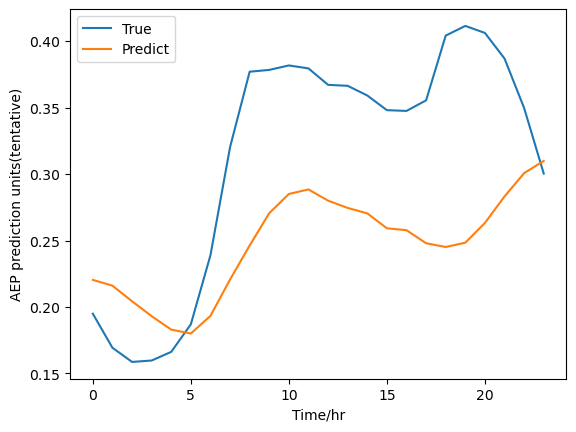

In [20]:
fig = plt.figure()
plt.plot(test_actual[0])
plt.plot(test_predict[0])
plt.xlabel('Time/hr')
plt.ylabel('AEP prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()


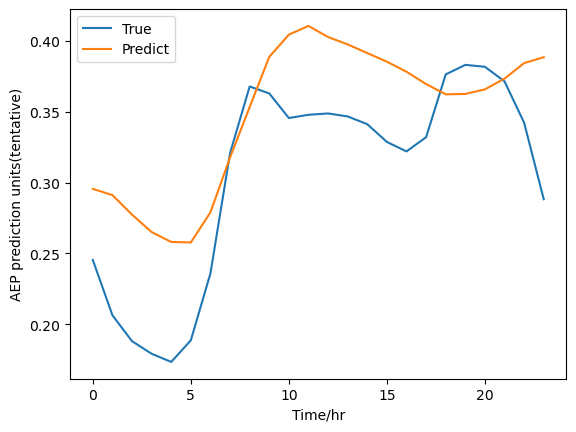

In [21]:
fig = plt.figure()
plt.plot(test_actual[1])
plt.plot(test_predict[1])
plt.xlabel('Time/hr')
plt.ylabel('AEP prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

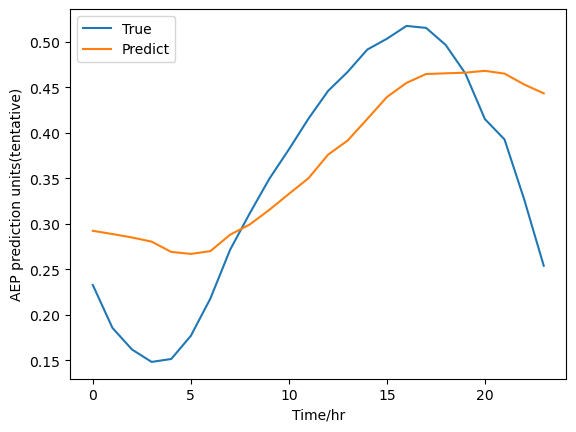

In [22]:
fig = plt.figure()
plt.plot(test_actual[200])
plt.plot(test_predict[200])
plt.xlabel('Time/hr')
plt.ylabel('AEP prediction units(tentative)')
plt.legend(['True', 'Predict'], loc='upper left')
plt.show()

###### 